<a href="https://colab.research.google.com/github/MUKESH-SK/Quantitative-Analysis-and-Finance/blob/main/Strategy_and_Backtesting2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importing Libraries**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# **Loading Dataset**

In [ ]:
dataset = pd.read_csv(r"/content/quant_analysis_dataset.csv") 
print(dataset)


           Date      Open      High       Low     Close  Adj Close  Volume
0    2022-01-01  0.079536  0.079056  0.079520  0.079051   0.079051  205008
1    2022-01-02  0.079043  0.080145  0.079351  0.080886   0.080886  208711
2    2022-01-03  0.080885  0.081274  0.080666  0.080963   0.080963  260036
3    2022-01-04  0.080962  0.081830  0.080832  0.082664   0.082664  305701
4    2022-01-05  0.082668  0.081933  0.080739  0.081489   0.081489  414546
..          ...       ...       ...       ...       ...        ...     ...
361  2022-12-28  0.072544  0.072498  0.071846  0.071891   0.071891  301565
362  2022-12-29  0.071893  0.072335  0.071976  0.072201   0.072201  248296
363  2022-12-30  0.072200  0.072226  0.072340  0.072232   0.072232  244279
364  2022-12-31  0.072239  0.072503  0.072164  0.072323   0.072323  182415
365  2023-01-01  0.072320  0.072381  0.072163  0.072238   0.072238  144341

[366 rows x 7 columns]


For this question also we use the same functions used previously in question2

# **Function for Calculating Simple Moving Averages (SMA)**


In [ ]:
def simple_moving_average(data, period):
    return data.rolling(window=period).mean()


# **Function for Calculating Exponential Moving Averages (EMA)**

In [ ]:
def EMA(data, period):
    alpha = 2/(period+1)
    # Calculate the EMA using the pandas rolling function
    ema = data.rolling(window=period).mean()
    # Add a weight factor to the EMA calculation
    ema = ema * (alpha) + data * (1-(alpha))
    return ema

# **Function for calculating Relative Strength Index (RSI)**

In [ ]:
def Calculate_RSI(data, period):
    # Create a new dataframe with the difference between consecutive close prices
    delta = data.diff()
    # Create a new dataframe with the gains
    gain = delta.where(delta > 0, 0)
    # Create a new dataframe with the losses
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(period).mean()
    avg_loss = loss.rolling(period).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rs,rsi
    # return pd.DataFrame({'RSI': rsi, 'Avg gain to loss ratio': rs})

In [ ]:
period = 14  # The number of data points to include in the EMA calculation
data = dataset['Close']
# RSI = np.array(Calculate_RSI(data, period))
RSI = Calculate_RSI(data, period)
#gain_to_lose stores avg_gain to avg_loss ratio
gain_to_lose =RSI[0]
# converting pandas series to numpy array
gain_to_lose_np =np.array(RSI[0])

# **Function for Calculating Moving Average Convergence/Divergence (MACD)**



In [ ]:
def macd(data, short_window, long_window, signal_window):
  # using ema function which is defined previously for calculating ema_short,ema_long
    ema_short = EMA(data, short_window)
    ema_long =  EMA(data, long_window)
    #applying the formula for finding macd,signal,histogram
    macd = ema_short - ema_long
    signal = macd.rolling(window=signal_window).mean()
    histogram = macd - signal
    return macd,signal,histogram

# **Function for Calculating Average True Range (ATR)**

In [ ]:
def calculate_atr(data, n):
    #creating df 'H-L' for storing absolute value of High - Low
    data['H-L'] = abs(data['High'] - data['Low'])
    #creating df 'H-PC' for storing absolute value of High - previous close
    data['H-PC'] = abs(data['High'] - data['Close'].shift(1))
    data['L-PC'] = abs(data['Low'] - data['Close'].shift(1))
    #creating df 'TR'(TRUE RANGE) for maximum of 'H-L', 'H-PC', 'L-PC'
    data['TR'] = data[['H-L', 'H-PC', 'L-PC']].max(axis=1)
    data['ATR'] = data['TR'].rolling(n).mean()
    return data['ATR']

# **Function for Calculating Finance Club Indicator(FCI)**

In [ ]:
# ATR_short  variable contains atr for period 7
ATR_short = np.array(calculate_atr(dataset, 7))
ATR_short1 = calculate_atr(dataset, 7)
# ATR_long  variable contains atr for period 21
ATR_long = np.array(calculate_atr(dataset, 21))
ATR_long1 = calculate_atr(dataset, 21)
# atr_ratio  variable contains ratio of ATR_short and ATR_long
atr_ratio_np =np.divide(ATR_short,ATR_long)
atr_ratio = pd.Series(atr_ratio_np)

In [ ]:
def Calculate_FCI(period):
  # multiplying gain_to_lose_np,atr_ratio_np
  multiply_deno= np.multiply(gain_to_lose_np,atr_ratio_np)
  fci_signal_np = 100-np.divide(100,(1+multiply_deno))
  # converting numpy fci_signal_np array to fci_signal series 
  fci_signal = pd.Series(fci_signal_np)
  # calculating fci_signal mean and storing in fci_mean
  fci_mean = fci_signal.rolling(window = period).mean()
  # calculating rsi mean and storing in rsi_mean
  rsi_mean = RSI[1].rolling(window = period).mean()
  # Applying the formula
  FCI = fci_mean - rsi_mean
  return FCI

# **Calculating the indicators**

creating a new columns in the same df and storing the values found using the function calls.

In [ ]:
dataset["macd"], dataset["macd_signal"], dataset["macd_hist"] = macd(dataset["Close"],26,12,9)
dataset["rsi"] = Calculate_RSI(dataset["Close"], 14)[1]
dataset["sma"] = simple_moving_average(dataset["Close"],21)
dataset["atr"] = calculate_atr(dataset,14)
dataset["fci"] = Calculate_FCI(10)

# **Creating the strategy**

In [ ]:
dataset["position"] = np.where((dataset["macd"] > dataset["macd_signal"]) & (dataset["rsi"] > 50) & (dataset["Close"] > dataset["sma"])&(dataset["fci"]>0), 1, 0)

By playing with these values we can adjust our loss or profit according to our wish ,(like changing (dataset["rsi"] > rsi ) values of rsi )

This code creates a new column "position" in the dataset and assigns a value of 1 or 0 based on the conditions specified in the np.where() function. The np.where() function is used to assign the values based on the specified conditions.

If all of these conditions are true, then the value assigned in the new column is 1, otherwise it is 0.

This new column "position" could be used for the purpose of identifying the trend of the stock for trading.






# **Calculating the returns**

In [ ]:
dataset["returns"] = np.log(dataset["Close"] / dataset["Close"].shift(1))
dataset["strategy_returns"] = dataset["position"] * dataset["returns"]

The first line of code calculates the log returns of the "Close" column in the dataset by dividing the current value by the previous value and taking the natural logarithm.
The second line of code calculates the strategy returns by multiplying the "position" column in the dataset by the returns calculated in the first line of code. The resulting "strategy_returns" column represents the returns generated by the strategy based on the positions taken in the "position" column.

# **Calculating the drawdown**

In [ ]:
# cumprod() function does cumulative product
dataset["cumulative_returns"] = (1 + dataset["strategy_returns"]).cumprod()
# cummax() function does cumulative sum
dataset["cumulative_drawdown"] = (dataset["cumulative_returns"] / dataset["cumulative_returns"].cummax()) - 1
print(np.array(dataset["cumulative_returns"]))
print(np.array(dataset["cumulative_drawdown"]))

[       nan 1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         0.99698613 1.00874576
 1.00874576 1.00874576 1.00874576 1.00874576 1.00874576 1.00874576
 1.00874576 1.00874576 1.00874576 1.00874576 1.00874576 1.00874576
 1.00874576 1.00874576 1.00874576 1.00874576 1.00874576 1.00874576
 1.00874576 1.04845144 1.05764656 1.05764656 1.05764656 1.05764656
 1.05764656 1.05764656 1.05764656 1.05764656 1.05764656 1.05764656
 1.05764656 1.05764656 1.05764656 1.05764656 1.05764656 1.05764656
 1.05764656 1.05764656 1.05764656 1.05764656 1.05764656 1.05764656
 1.05764656 1.05764656 1.05764656 1.05764656 1.05764656 1.05764656
 1.05764656 1.05764656 1.05764656 1.05764656 1.05764656 1.05764656
 1.05764656 1.05764656 1.05764656 1

The first line of code calculates the cumulative returns of the strategy by adding 1 to the "strategy_returns" column and then taking the cumulative product of the resulting values. This gives the overall growth of the strategy over time.

The second line of code calculates the cumulative drawdown of the strategy by dividing the "cumulative_returns" by its running maximum and then subtracting 1 from the result. This gives the percentage decrease from the strategy's historical peak returns at any given point in time.

# **Plot the results**

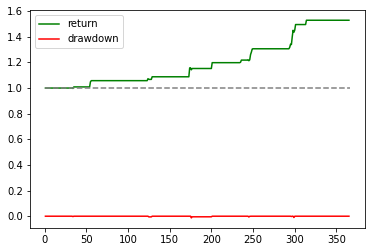

In [ ]:
y = []
x = []
for i in range(366):
  y.append(1)
  x.append(i+1)
# x is a list cantaining integers from 1 to 355,and y is list containing all its element as 1
plt.plot(dataset["cumulative_returns"],"green")
plt.plot(dataset["cumulative_drawdown"],"red")
plt.legend(["return", "drawdown"])
plt.plot(x,y,"grey",linestyle='dashed')
plt.show()

# **Conclusion**

The stratergy of using FCI along with macd,rsi,sma reduce the risk of losing as we can see clearly that the drawdown occurs very few number of times ,meanwhile our return is raising gradually.
In previous colab we used MACD,RSI,SMA in that statergy the return is increasing at very fast phase but the drawdown occurs a bit more than this statergy 
But in overall the macd,rsiand sma stratergy is good as it gives good amount returns